In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "02_ml_models/02a_machine_perception.ipynb"
_nb_title = "Flowers Image Classification using a linear model"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Flowers Image Classification using a linear model&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F02_ml_models%2F02a_machine_perception.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F02_ml_models%2F02a_machine_perception.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/02_ml_models/02a_machine_perception.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/02_ml_models/02a_machine_perception.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/02_ml_models/02a_machine_perception.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Flowers Image Classification using a linear model

We'll be using a creative-commons licensed 
[flower photo dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) 
of 3670 images falling into 5 categories:
<pre>
'daisy', 'roses', 'dandelion', 'sunflowers', and 'tulips'
</pre>
We have already prepared these images to be stored
in Google Cloud Storage in a public bucket:
<pre>
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/.
</pre>

The images are randomly split
into a training set with 90% data and a
test set with 10% data listed in CSV files:

Training set: [train_set.csv](https://storage.cloud.google.com/practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv)
Evaluation set: [eval_set.csv](https://storage.cloud.google.com/practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv)


## Enable GPU

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.0
Found GPU at: /device:GPU:0


## Let's examine these images

Let's see the first five lines of the train_set.csv
You'll notice that each line consists of a JPEG filename
and the type of flower it is.

In [ ]:
# Download the flowers dataset using TensorFlow Datasets
# This is a public dataset that doesn't require authentication
import tensorflow_datasets as tfds

# Load dataset info
(ds_train, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

print("Dataset info:")
print(ds_info)
print("\nNumber of classes:", ds_info.features['label'].num_classes)
print("Class names:", ds_info.features['label'].names)

gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg,roses
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/4558536575_d43a611bd4_n.jpg,dandelion
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/7568630428_8cf0fc16ff_n.jpg,daisy
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/7064813645_f7f48fb527.jpg,tulips
gs://practical-ml-vision-book-data/

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

# Get class names from the dataset info
(ds_train, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

CLASS_NAMES = ds_info.features['label'].names
print("These are the available classes:", CLASS_NAMES)

# Function to preprocess images from TFDS
def preprocess_image(image, label):
  # Convert image to float32 in [0,1] range
  img = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to the desired size
  img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


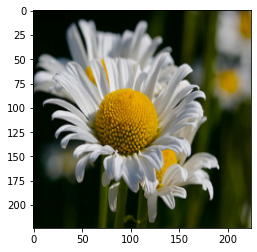

In [ ]:
# Try reading and displaying one image from the dataset
for image, label in ds_train.take(1):
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow(img.numpy())
  plt.title(f"Class: {CLASS_NAMES[label]}")
  plt.axis('off')
  plt.show()

gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/100930342_92e8746431_n.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10094729603_eeca3f2cb6.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10128546863_8de70c610d.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10163955604_ae0b830975_n.jpg


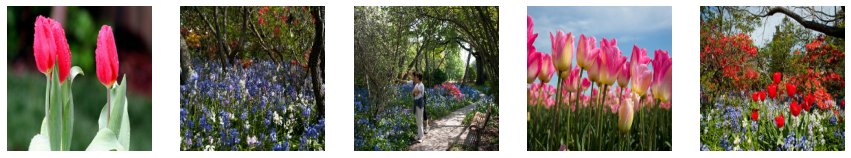

In [ ]:
# Let's look at a few tulips (label for tulips)
tulip_label = CLASS_NAMES.index('tulips')
f, ax = plt.subplots(1, 5, figsize=(15,15))

tulip_count = 0
for image, label in ds_train:
  if label == tulip_label and tulip_count < 5:
    img = tf.image.convert_image_dtype(image, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    ax[tulip_count].imshow(img.numpy())
    ax[tulip_count].axis('off')
    tulip_count += 1
  if tulip_count >= 5:
    break

In [ ]:
# Show the class name for a given label index
example_label = CLASS_NAMES.index('tulips')
print(f"Label {example_label} corresponds to: {CLASS_NAMES[example_label]}")

<tf.Tensor: shape=(), dtype=string, numpy=b'tulips'>

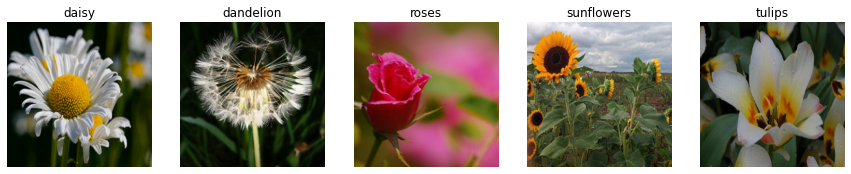

In [ ]:
# Display one example from each class
f, ax = plt.subplots(1, 5, figsize=(15,15))
examples_found = {i: False for i in range(len(CLASS_NAMES))}

for image, label in ds_train:
  label_idx = label.numpy()
  if not examples_found[label_idx]:
    img = tf.image.convert_image_dtype(image, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    ax[label_idx].imshow(img.numpy())
    ax[label_idx].set_title(CLASS_NAMES[label_idx])
    ax[label_idx].axis('off')
    examples_found[label_idx] = True
  
  # Break when we have one example of each class
  if all(examples_found.values()):
    break

## A simple rule-based model

Let's get the average color of RGB values in the different
types of flowers and then classify an unknown image as
belonging to closest centroid.

In [ ]:
# Preprocess the training dataset
train_dataset = ds_train.map(preprocess_image)

# Show average color for first few images
for img, label_idx in train_dataset.take(3):
  avg = tf.math.reduce_mean(img, axis=[0, 1]) # average pixel in the image
  label_name = CLASS_NAMES[label_idx]
  print(label_name, avg.numpy())

tf.Tensor(b'daisy', shape=(), dtype=string) tf.Tensor([0.35889465 0.36257476 0.26932985], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.32278505 0.32278505 0.32278505], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.20397638 0.13298166 0.07217269], shape=(3,), dtype=float32)


This will take a while if we do all the images,
since there are about 800 images
per type of flower. Later in the book, we will look at
ways to speed up full passes through the data.

In [ ]:
class Centroid:
  def __init__(self, label):
    self.label = label
    self.sum_so_far = tf.constant([0., 0., 0.], dtype=tf.float32)
    self.count_so_far = 0
  
  def update(self, value):
    self.sum_so_far = self.sum_so_far + value
    self.count_so_far = self.count_so_far + 1
    if self.count_so_far%100 == 0:
      print(self.label, self.count_so_far)

  def centroid(self):
    return self.sum_so_far / self.count_so_far

  def __str__(self):
    return '{} {}'.format(self.label, self.centroid().numpy())


class CentroidRule:
  def __init__(self):
    self.centroids = {
        i: Centroid(CLASS_NAMES[i]) for i in range(len(CLASS_NAMES))}

  def fit(self, dataset):
    for img, label_idx in dataset:
      label_idx = label_idx.numpy()
      avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
      self.centroids[label_idx].update(avg)
  
  def predict(self, img):
    avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
    best_label = 0
    best_diff = 999.0
    for key, val in self.centroids.items():
      diff = tf.reduce_sum(tf.abs(avg - val.centroid()))
      if diff < best_diff:
        best_diff = diff
        best_label = key
    return best_label
  
  def evaluate(self, dataset):
    num_correct, total_images = 0, 0
    for img, label_idx in dataset:
      correct = label_idx.numpy()
      predicted = self.predict(img)
      if correct == predicted:
        num_correct = num_correct + 1
      total_images = total_images + 1
    accuracy = num_correct / total_images
    return(accuracy)

In [ ]:
rule = CentroidRule()

# Prepare train and eval datasets (80/20 split)
# to try it on the full dataset, remove the .take(500)
train_dataset = ds_train.map(preprocess_image).take(500)
eval_dataset = ds_test.map(preprocess_image).take(50)

rule.fit(train_dataset)

# There is not much separation between the classes
daisy_idx = CLASS_NAMES.index('daisy')
roses_idx = CLASS_NAMES.index('roses')
print(rule.centroids[daisy_idx])
print(rule.centroids[roses_idx])

# let's evaluate it
accuracy = rule.evaluate(eval_dataset)
print(f"Accuracy: {accuracy:.4f}")

dandelion 100
tulips 100
daisy [0.44554377 0.44968474 0.3594977 ]
roses [0.46776444 0.37675467 0.31471127]


0.24

That's pretty much a random guess!!

In [ ]:
# this is how you'd use the model to predict
for image, label in eval_dataset.take(1):
  pred_idx = rule.predict(image)
  pred_name = CLASS_NAMES[pred_idx]
  actual_name = CLASS_NAMES[label.numpy()]
  print(f"Predicted: {pred_name}, Actual: {actual_name}")

tulips


## A linear model
What if you apply different weights each of the pixels?
Let's use the Keras API

In [ ]:
# Prepare datasets for training the linear model
train_dataset = ds_train.map(preprocess_image).batch(10)
eval_dataset = ds_test.map(preprocess_image).batch(10)

# linear model
model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


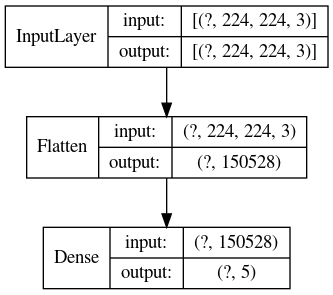

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [10]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
330/330 [==============================] - 931s 3s/step - loss: 15.9920 - accuracy: 0.3476 - val_loss: 10.3957 - val_accuracy: 0.3973
Epoch 2/10
330/330 [==============================] - 712s 2s/step - loss: 15.2134 - accuracy: 0.4055 - val_loss: 12.4511 - val_accuracy: 0.4108
Epoch 3/10
330/330 [==============================] - 632s 2s/step - loss: 12.0321 - accuracy: 0.4558 - val_loss: 27.7763 - val_accuracy: 0.3838
Epoch 4/10
330/330 [==============================] - 565s 2s/step - loss: 15.6114 - accuracy: 0.4652 - val_loss: 26.0203 - val_accuracy: 0.4000
Epoch 5/10
330/330 [==============================] - 579s 2s/step - loss: 10.3331 - accuracy: 0.5436 - val_loss: 22.7779 - val_accuracy: 0.3946
Epoch 6/10
330/330 [==============================] - 536s 2s/step - loss: 12.0866 - accuracy: 0.5306 - val_loss: 47.9555 - val_accuracy: 0.3405
Epoch 7/10
330/330 [==============================] - 521s 2s/step - loss: 16.8828 - accuracy: 0.4982 - val_loss: 24.7191 - val_ac

In [33]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

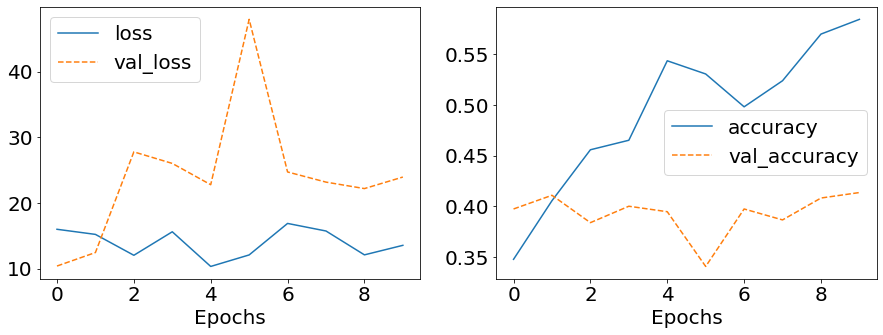

In [34]:
training_plot(['loss', 'accuracy'], history);

[0.09405971 0.0570501  0.8488902 ]
[0.04838873 0.0721875  0.8794238 ]


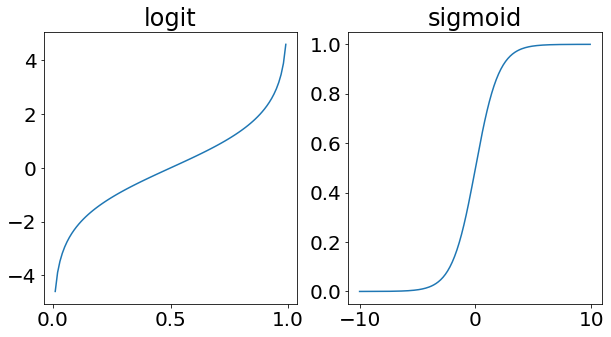

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 2, figsize=(10,5))
x = np.arange(0.01, 1.0, 0.01)
y = np.log(x / (1-x))
ax[0].plot(x, y)
ax[0].set_title("logit")
x = np.arange(-10.0, 10.0, 0.1)
y = tf.math.sigmoid(x)
ax[1].plot(x, y);
ax[1].set_title("sigmoid")

print( tf.math.softmax([-1.0, -1.5, 1.2]).numpy() )
print( tf.math.softmax([0.1, 0.5, 3.0]).numpy() )

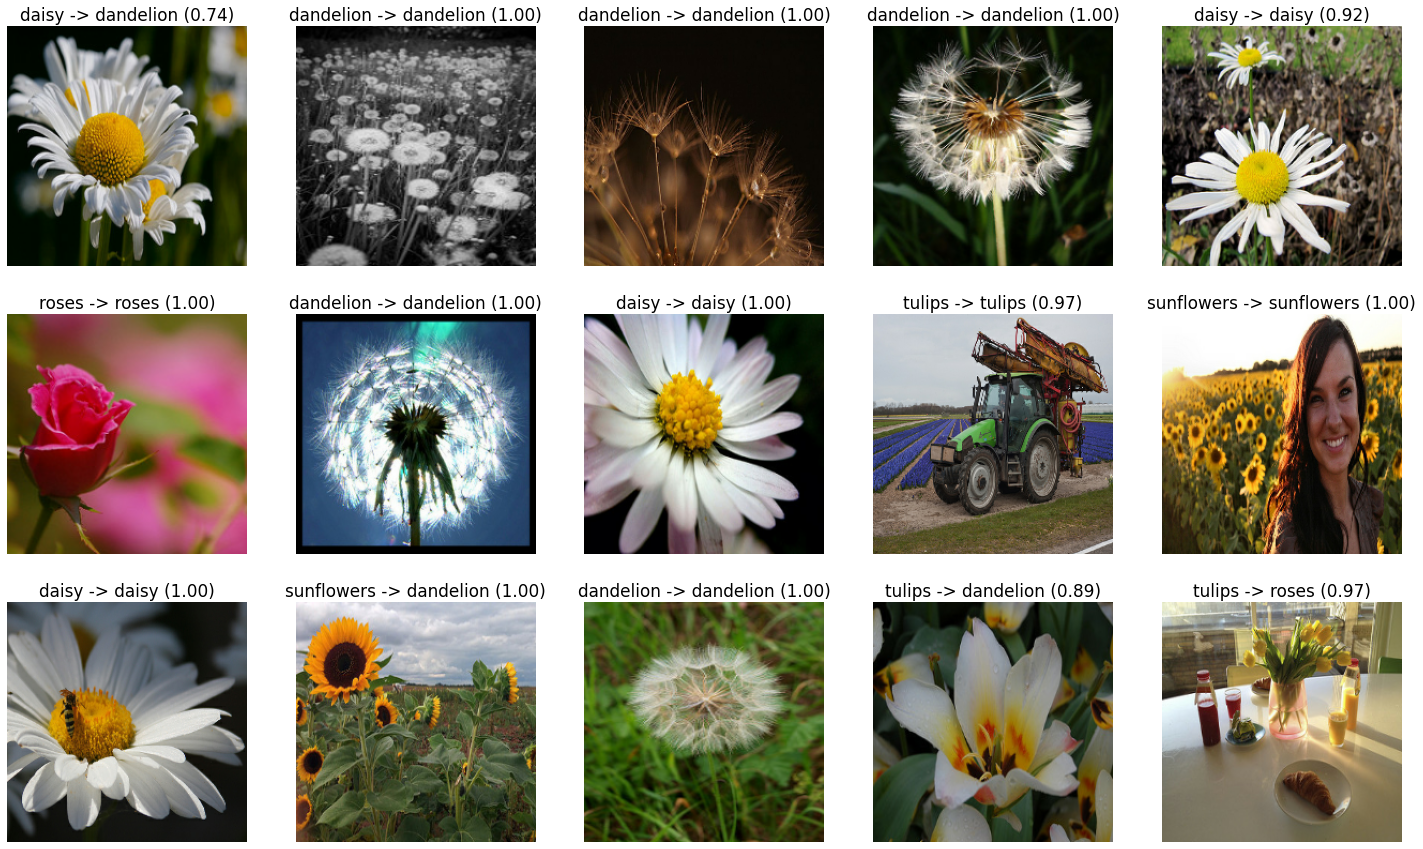

In [ ]:
# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(dataset, title="Predictions"):
  matplotlib.rcParams.update({'font.size': 14})
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset_preprocessed = dataset.map(preprocess_image)
  for idx, (img, label_idx) in enumerate(dataset_preprocessed.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()))
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image, verbose=0)
    pred = batch_pred[0]
    label = CLASS_NAMES[label_idx.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')
  f.suptitle(title, fontsize=20)

plot_predictions(ds_train, "Training Set Predictions")

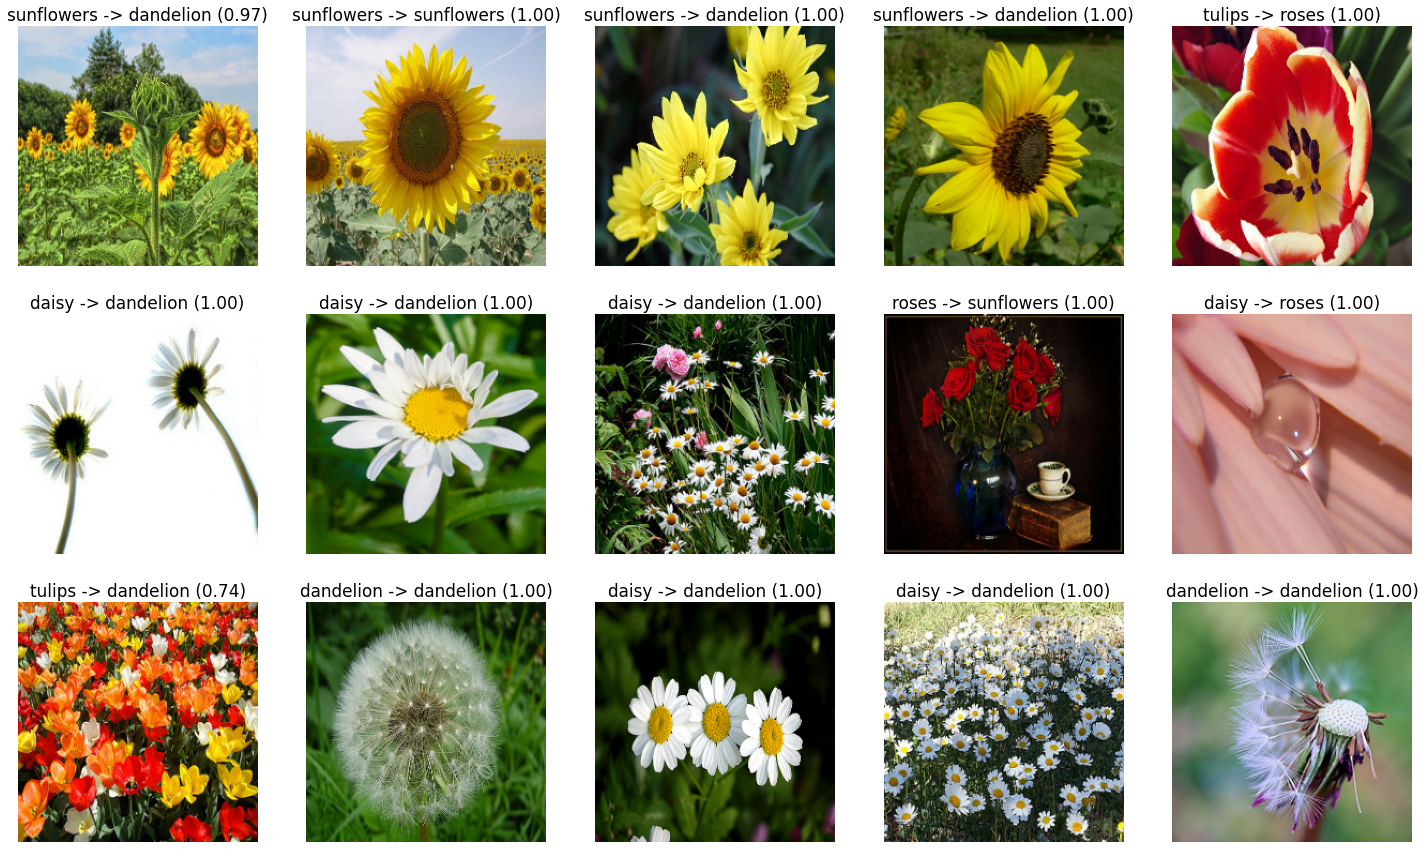

In [ ]:
plot_predictions(ds_test, "Evaluation Set Predictions")

Scaling weights for daisy in -0.1400132030248642 to 0.11755678057670593
Scaling weights for dandelion in -0.1194157525897026 to 0.1433272659778595
Scaling weights for roses in -0.11747615039348602 to 0.12644261121749878
Scaling weights for sunflowers in -0.14917171001434326 to 0.12388180941343307
Scaling weights for tulips in -0.11622291058301926 to 0.11004119366407394


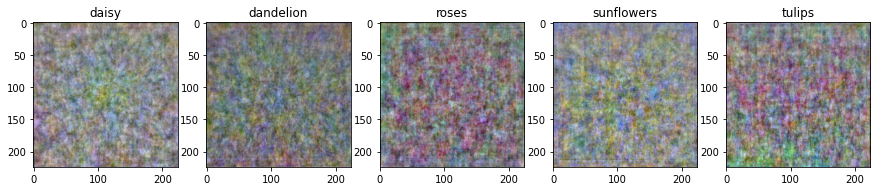

In [ ]:
def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

show_trained_weights(model)

## Diagrams


[0.   0.09 0.06 0.85 0.  ] [0.         0.01696592 0.01094963 0.9720845  0.        ]
[0.09090909 0.09090909 0.6363636  0.09090909 0.09090909] [0.04651164 0.04651164 0.8139535  0.04651164 0.04651164]
[0.   0.25 0.5  0.25 0.  ] [0.         0.20000002 0.6000001  0.20000002 0.        ]
[0.08333333 0.08333333 0.3333333  0.41666666 0.08333333] [0.06113537 0.06113537 0.33624455 0.48034936 0.06113537]
[0.12499999 0.12499999 0.49999997 0.12499999 0.12499999] [0.09090909 0.09090909 0.6363636  0.09090909 0.09090909]


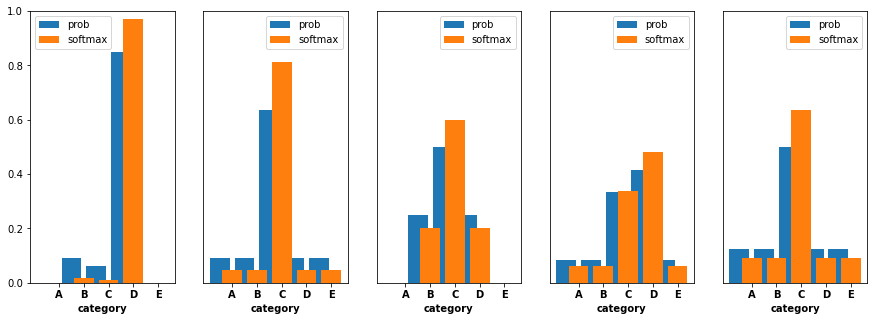

In [60]:
import tensorflow as tf

inx = [
    [0, 0.09, 0.06, 0.85, 0],
    [0.1, 0.1, 0.7, 0.1, 0.1],
    [0, 0.2, 0.4, 0.2, 0],
    [0.1, 0.1, 0.4, 0.5, 0.1],
    [0.2, 0.2, 0.8, 0.2, 0.2],
]

def logit(x):
    return - tf.math.log(1. / x - 1.)

barWidth = 0.5
r1 = np.arange(len(inx[0]))
r2 = [x + barWidth for x in r1]

f, ax = plt.subplots(1, 5, figsize=(15,5))
for idx, x in enumerate(inx):
    prob = x / tf.reduce_sum(x)
    softmax = tf.nn.softmax(logit(prob))
    print(prob.numpy(), softmax.numpy())
    ax[idx].bar(r1, prob, label='prob')
    ax[idx].bar(r2, softmax, label='softmax')
    ax[idx].set_xlabel('category', fontweight='bold')
    ax[idx].set_xticks(r2)
    ax[idx].set_xticklabels(['A','B','C','D','E'], fontweight='bold')
    ax[idx].set_ylim([0,1])
    if idx > 0:
        ax[idx].yaxis.set_visible(False)
    ax[idx].legend()

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.